In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
import random
import Categorization
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
from PIL import Image
import os



In [2]:
sepsisDF = pd.read_csv('../LEN_Test/data/sepsis_data.csv')

sepsisDF

Patient_id     HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  \
0          p116812    NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN   
1          p116812  102.0  100.0    NaN    NaN   NaN   NaN  22.0    NaN   
2          p116812  102.0  100.0    NaN   99.0  84.0  76.0  18.5    NaN   
3          p116812  124.0  100.0    NaN   97.0  70.0  55.0  16.0    NaN   
4          p116812   98.0  100.0    NaN   95.0  73.0  62.0  18.0    NaN   
...            ...    ...    ...    ...    ...   ...   ...   ...    ...   
1552205    p005863   86.0   97.0    NaN  121.0  80.0  58.0  21.0    NaN   
1552206    p005863   86.0   96.0    NaN  112.0  73.0  53.0  18.0    NaN   
1552207    p005863   82.0   95.0    NaN  102.0  72.0  55.0  18.0    NaN   
1552208    p005863   80.0   96.0  36.11   86.0  60.0  46.0  20.0    NaN   
1552209    p005863   84.0   94.0    NaN   91.0  62.0  47.0  20.0    NaN   

         BaseExcess  ...  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  \
0               NaN  ...  NaN         NaN        NaN  59.00       1    1.0   
1               NaN  ...  NaN         NaN        NaN  59.00       1    1.0   
2               NaN  ...  NaN         NaN        NaN  59.00       1    1.0   
3               NaN  ...  NaN         NaN        NaN  59.00       1    1.0   
4               NaN  ...  6.8         NaN      276.0  59.00       1    1.0   
...             ...  ...  ...         ...        ...    ...     ...    ...   
1552205         NaN  ...  NaN         NaN        NaN  66.47       1    0.0   
1552206         NaN  ...  NaN         NaN        NaN  66.47       1    0.0   
1552207         NaN  ...  NaN         NaN        NaN  66.47       1    0.0   
1552208         NaN  ...  NaN         NaN        NaN  66.47       1    0.0   
1552209         0.0  ...  NaN         NaN        NaN  66.47       1    0.0   

         Unit2  HospAdmTime  ICULOS  SepsisLabel  
0          0.0        -6.01       1            0  
1          0.0        -6.01       2            0  
2          0.0        -6.01       3            0  
3          0.0        -6.01       4            0  
4          0.0        -6.01       5            0  
...        ...          ...     ...          ...  
1552205    1.0       -12.88      15            0  
1552206    1.0       -12.88      16            0  
1552207    1.0       -12.88      17            0  
1552208    1.0       -12.88      18            0  
1552209    1.0       -12.88      19            0  

[1552210 rows x 42 columns]

In [3]:
# Too many columns to display all in one cell.

step = 10

for idx in range(0, len(sepsisDF.columns), step):
    tempCols = sepsisDF.columns[idx:idx+step]
    display(sepsisDF[tempCols].head(10))

Patient_id     HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  BaseExcess
0    p116812    NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN         NaN
1    p116812  102.0  100.0   NaN    NaN   NaN   NaN  22.0    NaN         NaN
2    p116812  102.0  100.0   NaN   99.0  84.0  76.0  18.5    NaN         NaN
3    p116812  124.0  100.0   NaN   97.0  70.0  55.0  16.0    NaN         NaN
4    p116812   98.0  100.0   NaN   95.0  73.0  62.0  18.0    NaN         NaN
5    p116812  101.0  100.0   NaN  120.0  85.0  68.0  21.0    NaN         NaN
6    p116812  101.0  100.0  36.6  120.0  85.0  68.0  20.0    NaN         NaN
7    p116812  102.0   96.0   NaN  103.0  73.0  58.0   NaN    NaN         NaN
8    p116812   91.0  100.0   NaN   89.0  66.0  54.0   NaN    NaN         NaN
9    p116812  102.0   99.0   NaN  103.0  78.0  62.0  20.0    NaN         NaN

HCO3  FiO2  pH  PaCO2  SaO2   AST   BUN  Alkalinephos  Calcium  Chloride
0   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
1   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
2   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
3   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
4   NaN   NaN NaN    NaN   NaN  11.0  13.0          38.0      8.0       NaN
5   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
6   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
7   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
8   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN
9   NaN   NaN NaN    NaN   NaN   NaN   NaN           NaN      NaN       NaN

Creatinine  Bilirubin_direct  Glucose  Lactate  Magnesium  Phosphate  \
0         NaN               NaN      NaN      NaN        NaN        NaN   
1         NaN               NaN      NaN      NaN        NaN        NaN   
2         NaN               NaN      NaN      NaN        NaN        NaN   
3         NaN               NaN      NaN      NaN        NaN        NaN   
4        1.16               NaN    105.0      NaN        NaN        3.1   
5         NaN               NaN      NaN      NaN        NaN        NaN   
6         NaN               NaN      NaN      NaN        NaN        NaN   
7         NaN               NaN      NaN      NaN        NaN        NaN   
8         NaN               NaN      NaN      NaN        NaN        NaN   
9         NaN               NaN      NaN      NaN        NaN        NaN   

   Potassium  Bilirubin_total  TroponinI   Hct  
0        NaN              NaN        NaN   NaN  
1        NaN              NaN       0.03   NaN  
2        NaN              NaN        NaN   NaN  
3        NaN              NaN        NaN   NaN  
4        4.1              0.3        NaN  23.1  
5        NaN              NaN        NaN   NaN  
6        NaN              NaN        NaN   NaN  
7        NaN              NaN        NaN   NaN  
8        NaN              NaN        NaN   NaN  
9        NaN              NaN        NaN   NaN

Hgb  PTT  WBC  Fibrinogen  Platelets   Age  Gender  Unit1  Unit2  \
0  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
1  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
2  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
3  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
4  7.5  NaN  6.8         NaN      276.0  59.0       1    1.0    0.0   
5  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
6  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
7  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
8  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   
9  NaN  NaN  NaN         NaN        NaN  59.0       1    1.0    0.0   

   HospAdmTime  
0        -6.01  
1        -6.01  
2        -6.01  
3        -6.01  
4        -6.01  
5        -6.01  
6        -6.01  
7        -6.01  
8        -6.01  
9        -6.01

ICULOS  SepsisLabel
0       1            0
1       2            0
2       3            0
3       4            0
4       5            0
5       6            0
6       7            0
7       8            0
8       9            0
9      10            0

In [4]:
# sepsisDF = sepsisDF.drop(columns=['ICULOS'])

In [5]:
print(f"There are {sepsisDF['Patient_id'].nunique()} unique patients in the dataset")

There are 40336 unique patients in the dataset


In [6]:
print(sepsisDF['SepsisLabel'].value_counts())

0    1524294
1      27916
Name: SepsisLabel, dtype: int64


In [7]:
th = TH()

staticColumns = ["Age", "Gender", "Unit1", "Unit2", "HospAdmTime", "ICULOS"]

patients = th.get_patients(sepsisDF, by="Patient_id", label="SepsisLabel", static = staticColumns)

100%|██████████| 40336/40336 [01:24<00:00, 478.02it/s]


In [8]:
patients[0].data.head()

HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...   
4  103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI  Hct  Hgb  PTT  WBC  \
0        NaN        NaN              NaN        NaN  NaN  NaN  NaN  NaN   
1        NaN        NaN              NaN        NaN  NaN  NaN  NaN  NaN   
2        NaN        NaN              NaN        NaN  NaN  NaN  NaN  NaN   
3        NaN        NaN              NaN        NaN  NaN  NaN  NaN  NaN   
4        NaN        NaN              NaN        NaN  NaN  NaN  NaN  NaN   

   Fibrinogen  Platelets  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  

[5 rows x 34 columns]

In [9]:
patients[0].static.head()

Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS
786527  83.14       0    NaN    NaN        -0.03       1
786528  83.14       0    NaN    NaN        -0.03       2
786529  83.14       0    NaN    NaN        -0.03       3
786530  83.14       0    NaN    NaN        -0.03       4
786531  83.14       0    NaN    NaN        -0.03       5

In [10]:
totalNullColumns = 0

for patient in tqdm(patients):
    totalNullColumns += patient.data.isnull().all().sum()

totalColumns = len(patient.data.columns) * len(patients)

print(totalColumns, totalNullColumns)

print(f"{np.round(totalNullColumns / totalColumns * 100, 2)}% of columns are null")

100%|██████████| 40336/40336 [00:17<00:00, 2269.94it/s]

1371424 477941
34.85% of columns are null


Counting how many columns have no data in 

[1/4] Counting null values...


100%|██████████| 40336/40336 [00:21<00:00, 1906.12it/s]


[2/3] Copying dataset...
[3/4] Dropping null columns...


100%|██████████| 34/34 [01:30<00:00,  2.66s/it]


[4/4] Graphing...


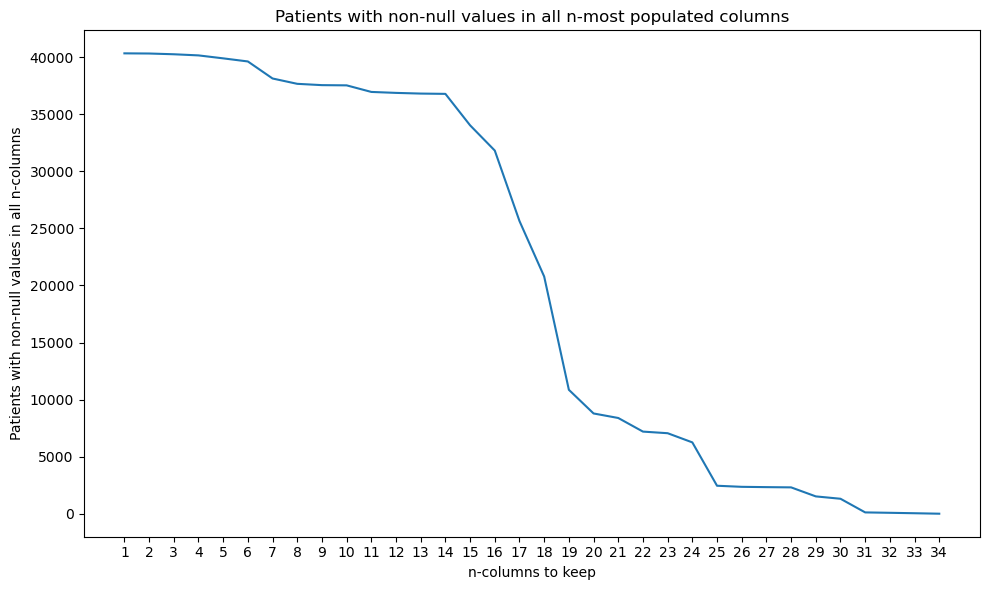

In [11]:
# reload(temporalHelper)

# th = temporalHelper.TemporalHelper()

patientsKept, columnsExplored = th.count_null(patients)

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [12]:
clusteringPatients = th.get_top_columns(patients, 15)

print(len(clusteringPatients))

clusteringPatients[3].topColumns.head()

100%|██████████| 40336/40336 [00:15<00:00, 2540.27it/s]

34028


HR  O2Sat  Resp   MAP    SBP   Temp  Glucose  Potassium   BUN  \
0    NaN    NaN   NaN   NaN    NaN    NaN      NaN        NaN   NaN   
1  103.5   97.0  18.0  70.5  107.5    NaN      NaN        NaN  14.0   
2  108.0   98.5  19.5  82.0  124.5  36.78    253.0        5.0   NaN   
3  107.5   96.5  17.0  77.5  117.5    NaN      NaN        NaN   NaN   
4  113.0  100.0  26.0  80.0  125.0    NaN      NaN        NaN   NaN   

   Creatinine   Hct  Hgb  Platelets  WBC  Magnesium  
0         NaN   NaN  NaN        NaN  NaN        NaN  
1         0.8  27.6  NaN      220.0  NaN        1.7  
2         NaN   NaN  NaN        NaN  NaN        NaN  
3         NaN   NaN  NaN        NaN  NaN        NaN  
4         NaN   NaN  NaN        NaN  NaN        NaN

In [13]:
# Sanity check

totalNullColumns = 0

for patient in tqdm(clusteringPatients):
    totalNullColumns += patient.topColumns.isnull().all().sum()

totalColumns = len(patient.topColumns.columns) * len(clusteringPatients)

print(totalColumns, totalNullColumns)

print(f"{np.round(totalNullColumns / totalColumns * 100, 2)}% of columns are null")

100%|██████████| 34028/34028 [00:13<00:00, 2431.90it/s]

510420 0
0.0% of columns are null


In [14]:
# x = clusteringPatients[0].interpolatedData['Platelets']
# print(x.shape[0]/48)
# x.index = pd.to_datetime(x.index, unit="ms")
# x = x.resample(f"{x.shape[0]//48}ms").asfreq()
# x


# for patient in tqdm(clusteringPatients):
    
#     fixedData = []

#     patient.interpolatedData.index = pd.to_datetime(patient.interpolatedData.index, unit="ms")

#     patient.interpolatedData.apply(lambda x: fixedData.append(x.resample(f"{(x.shape[0]/48)}ms").asfreq()))

#     tempDF = pd.DataFrame(data = fixedData).T
#     tempDF.columns = patient.interpolatedData.columns
#     patient.interpolatedData = tempDF

#     print(patient.interpolatedData.shape)




In [15]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0
failureExample = (0,0)

maxPatientLen = 0

tempCP = copy.deepcopy(clusteringPatients)


for idx, patient in (enumerate(tempCP)):

    # print(patient.topColumns)

    if patient.data.shape[0] > maxPatientLen:
        maxPatientLen = patient.data.shape[0]

print("Max time series length: " + str(maxPatientLen))


for patient in tqdm(tempCP):

    if patient.topColumns.shape[0] < maxPatientLen:


        fixedData = []
        for col in patient.topColumns:
            fixedData.append(np.pad(patient.topColumns[col], (0, maxPatientLen - patient.topColumns[col].shape[0]), 'constant', constant_values=np.nan))

        # print(fixedData)

        tempDF = pd.DataFrame(data = fixedData).T
        tempDF.columns = patient.topColumns.columns
        patient.topColumns = tempDF

    patientNonNullCount = patient.topColumns.count()

    for column in patient.topColumns.columns:

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='polynomial', order=2, limit_direction='both', limit_area='inside')

    
        except ValueError:

            try:

                if patientNonNullCount[column] == 1:
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit=3)
                else: 
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit_area='inside')
            
            except ValueError:

                patient.interpolatedData[column] = patient.topColumns[column].fillna(patient.topColumns[column].mean())
                noInterpolation += 1
                # failureExample = (idx, column)


        # if patient.interpolatedData[column].shape[0] < 48:
        #     print("Got here")
        #     patient.interpolatedData[column] = np.pad(patient.interpolatedData[column], (0, 48 - patient.interpolatedData[column]), 'constant', constant_values=np.nan)

    

# Is this true?
print(f"{noInterpolation}/{len(clusteringPatients)} patients failed to interpolate")
# print(f"{failureExample}")

Max time series length: 336


100%|██████████| 34028/34028 [17:48<00:00, 31.84it/s]  

0/34028 patients failed to interpolate


In [16]:
clusteringPatients = tempCP

In [17]:
clusteringPatients[4].interpolatedData

PatientID    HR  O2Sat  Resp         MAP    SBP       Temp  Glucose  \
1344   p000005  84.0   97.5  17.5   94.500000  140.5  37.280000      NaN   
1345   p000005  80.0   99.0  18.0   99.000000  150.0  37.227660      NaN   
1346   p000005  74.0   97.0  19.0  103.000000  142.0  37.220000      NaN   
1347   p000005  73.0   98.0  17.0   99.000000  144.0  37.257019      NaN   
1348   p000005  71.0   97.0  17.0   93.501172  144.0  37.338717    138.0   
...        ...   ...    ...   ...         ...    ...        ...      ...   
1675   p000005   NaN    NaN   NaN         NaN    NaN        NaN      NaN   
1676   p000005   NaN    NaN   NaN         NaN    NaN        NaN      NaN   
1677   p000005   NaN    NaN   NaN         NaN    NaN        NaN      NaN   
1678   p000005   NaN    NaN   NaN         NaN    NaN        NaN      NaN   
1679   p000005   NaN    NaN   NaN         NaN    NaN        NaN      NaN   

      Potassium  BUN  Creatinine   Hct   Hgb  Platelets  WBC  Magnesium  
1344        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1345        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1346        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1347        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1348        3.1  7.0         0.6  41.0  14.2      273.0  8.1        1.9  
...         ...  ...         ...   ...   ...        ...  ...        ...  
1675        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1676        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1677        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1678        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  
1679        NaN  NaN         NaN   NaN   NaN        NaN  NaN        NaN  

[336 rows x 16 columns]

In [18]:
withIDs = []

for patient in clusteringPatients:
    tempP = copy.deepcopy(patient)
    tempP.interpolatedData['PatientID'] = tempP.patientID
    tempP.interpolatedData['Mortality14Days'] = tempP.label
    withIDs.append(tempP)


cleanedTimeSeriesDF = pd.concat([patient.interpolatedData for patient in withIDs])

cleanedTimeSeriesDF = cleanedTimeSeriesDF.set_index('PatientID')

# cleanedTimeSeriesDF['Mortality14Days'] = mortality

cleanedTimeSeriesDF.to_csv("cleanedTemporalSepsisData.csv")

In [ ]:
class Patient:

    def __init__(self, patientID, label, data, static=None):
        self.patientID = patientID
        self.data = data
        self.interpolatedData = pd.DataFrame()
        self.label = label
        if static is not None:
            self.static=static


    def __repr__(self):
        return f"PatientID: {self.patientID}\n Readings: {self.data.to_string()}"



# Reload cached interpolated data from here 

#### Saves about 20 mins of processing

In [3]:
sepsisDF = pd.read_csv('../LEN_Test/data/sepsis_data.csv')

th = TH()

staticColumns = ["Age", "Gender", "Unit1", "Unit2", "HospAdmTime", "ICULOS"]

patients = th.get_patients(sepsisDF, by="Patient_id", label="SepsisLabel", static = staticColumns)

patientsDict = {patient.patientID : patient for patient in patients}

cleanedTimeSeriesDF = pd.read_csv("./LSTMs/cleanedTemporalSepsisData.csv")


loadedIDs = set(cleanedTimeSeriesDF['PatientID'].unique())

# inclusionIDs = [id for id in patientsDict if id in loadedIDs]

for id, group in tqdm(cleanedTimeSeriesDF.groupby("PatientID")):
    label = group.iloc[0]['Mortality14Days']
    group = group.drop(columns=['PatientID', 'Mortality14Days'], axis=1)
    patientsDict[id].interpolatedData = group

clusteringPatients = [patientsDict[id] for id in patientsDict if id in loadedIDs]

 12%|█▏        | 4838/40336 [00:10<01:16, 464.40it/s]


KeyboardInterrupt: 

In [10]:
print(len(clusteringPatients))

34028


In [20]:
# def plotPatient(patient=1, feature='Platelets'):

#     patient = clusteringPatients[patient]

#     # fig = plt.figure(figsize = (30, 1.5))

#     # plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)
#     # plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
#     # plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
#     # plt.scatter(patient.topColumns.index, patient.topColumns[col])
#     # plt.title(f"Patient: {patient}")

#     fig = plt.figure()
    
#     fig.show()

#     ax = fig.add_subplot(1,1,1)

#     ax.plot(patient.interpolatedData[feature])

#     ax.scatter(patient.interpolatedData[feature].index, patient.interpolatedData[feature])

#     ax.scatter(patient.topColumns[feature].index, patient.topColumns[feature], c="Orange")


#     output = ax.get_figure()

#     plt.close(output)

#     return output


C:\Users\benma\AppData\Local\Temp/ipykernel_18404/846929100.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


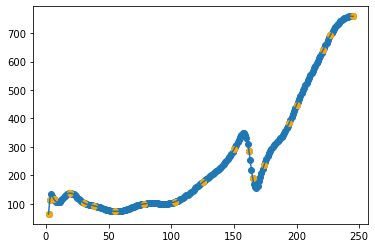

In [21]:
# plotPatient(7, 'Platelets')

In [22]:
# import panel as pn

# pn.extension()

# pn.interact(plotPatient, patient=(1, len(clusteringPatients)), feature = list(clusteringPatients[0].interpolatedData.columns)).show()

Launching server at http://localhost:64789


C:\Users\benma\AppData\Local\Temp/ipykernel_18404/846929100.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [22]:
patient = clusteringPatients[1]

fig = plt.figure(figsize = (30, 8), dpi=200)


fig.suptitle(f"Patient: {patient.patientID}", fontsize=30)

for idx, col in enumerate(patient.topColumns.columns):
    plt.subplot(2, (len(patient.topColumns.columns)//2)+1, idx+1)

    plt.scatter(patient.topColumns.index, patient.topColumns[col], c='Orange')
    plt.title(f"{col}", fontsize=20)

plt.tight_layout()
plt.show()

AttributeError: 'Patient' object has no attribute 'topColumns'

<Figure size 6000x1600 with 0 Axes>

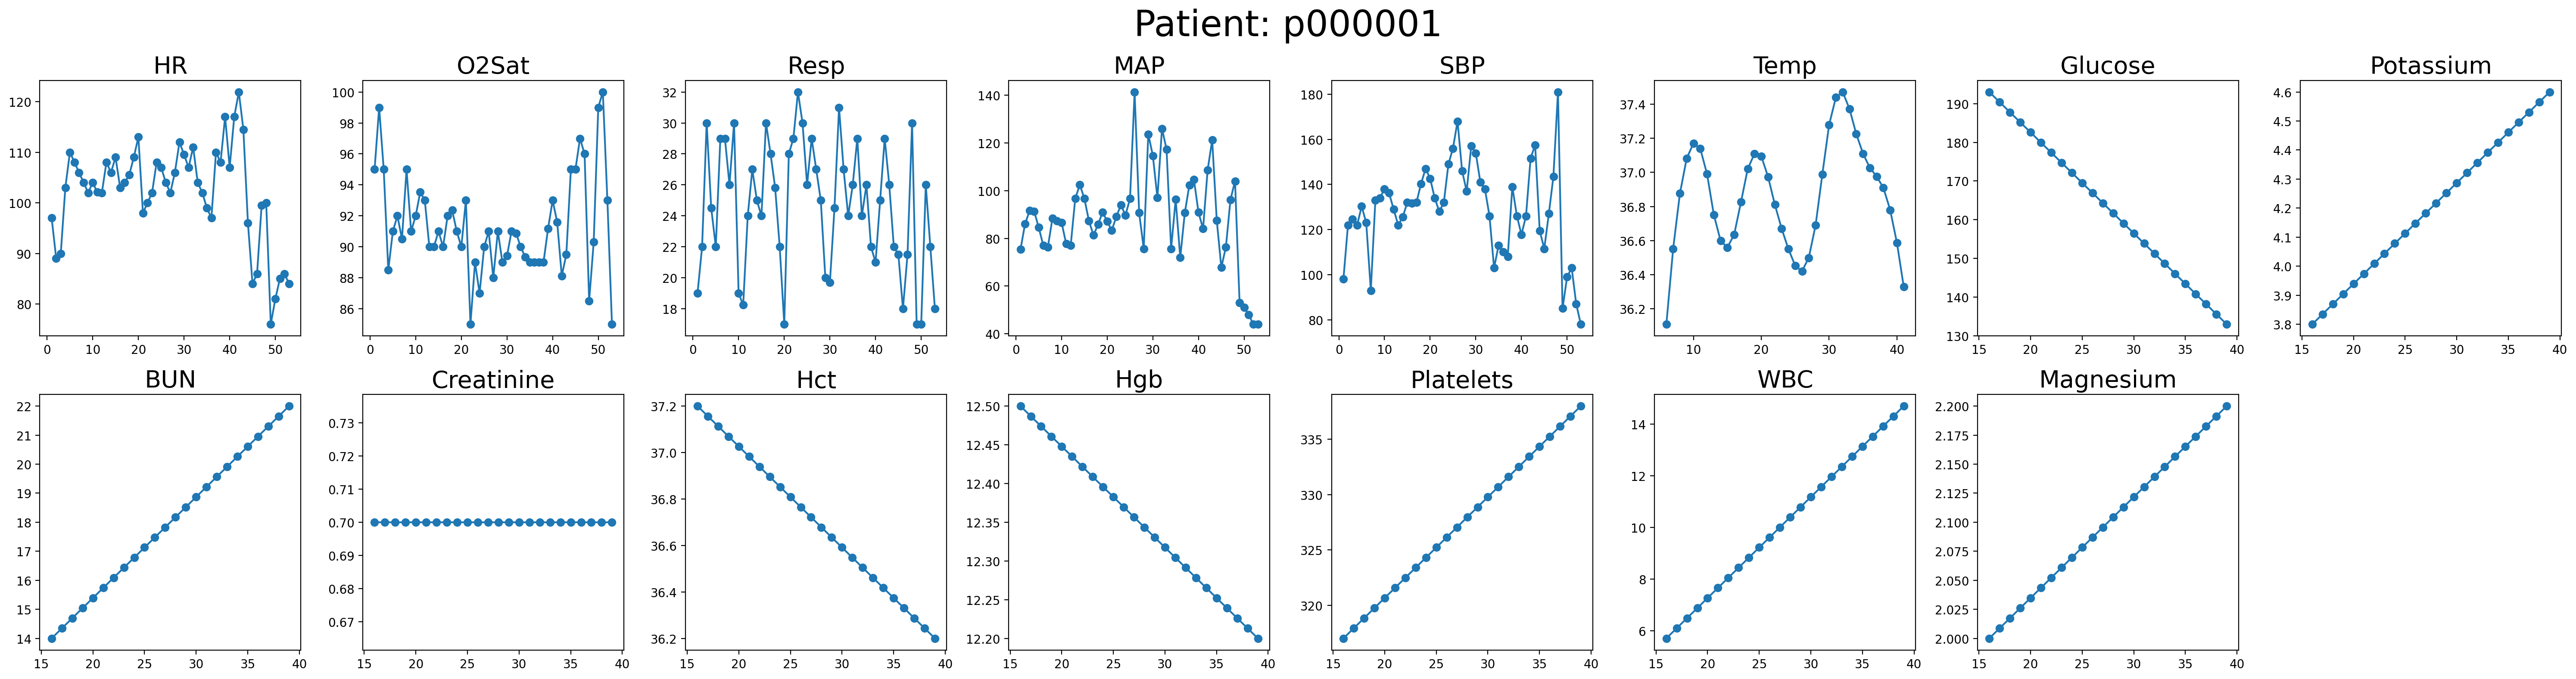

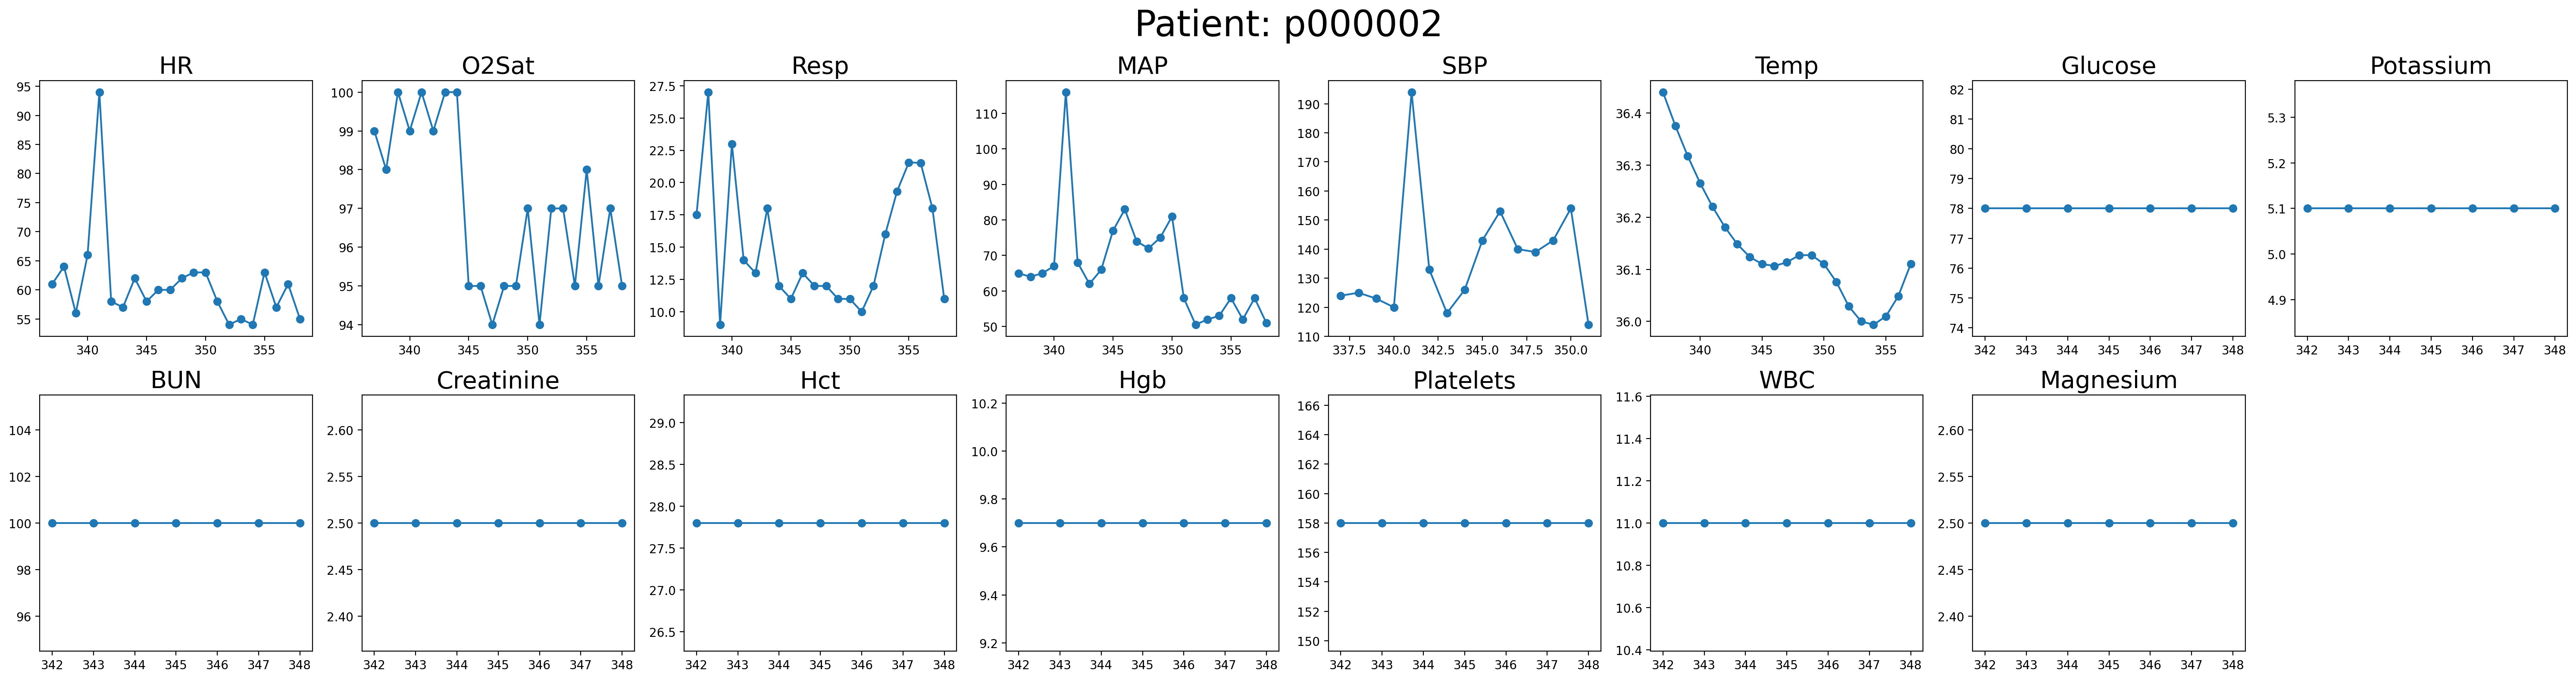

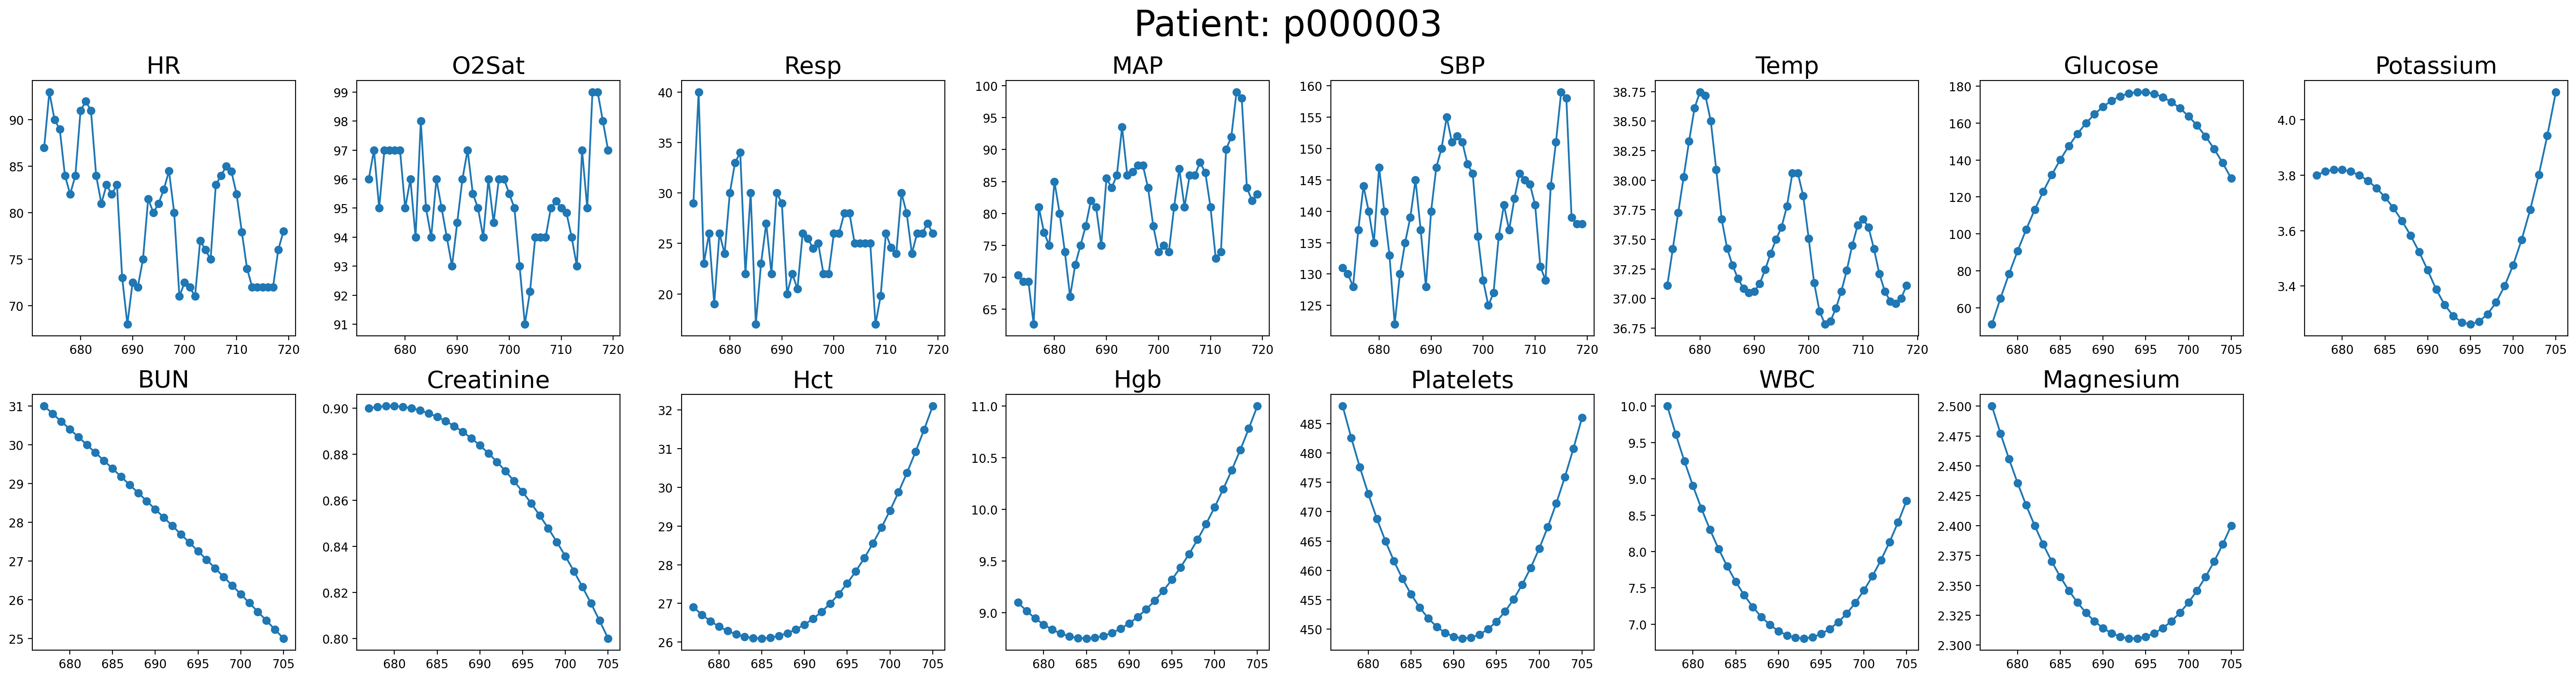

In [23]:
for patient in clusteringPatients[:3]:

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 8),dpi=200)


    fig.suptitle(f"Patient: {patient.patientID}", fontsize=30)

    for idx, col in enumerate(patient.interpolatedData.columns):
        plt.subplot(2, (len(patient.interpolatedData.columns)//2)+1, idx+1)

        plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
        plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
        # plt.scatter(patient.topColumns.index, patient.topColumns[col], c="Orange")
        plt.title(f"{col}", fontsize=20)

    plt.tight_layout()
    plt.show()

In [14]:
minorityClass = [patient for patient in clusteringPatients if patient.label == 1]
majorityClass = [patient for patient in clusteringPatients if patient.label == 0]

print(len(minorityClass))
print(len(majorityClass))

2422
31606


In [12]:

def formatForTimeSeries(column, sampleSize=None):

    if sampleSize is None:
        sampleList = clusteringPatients
    else:
        minorityClass = [patient for patient in clusteringPatients if patient.label == 1]
        majorityClass = [patient for patient in clusteringPatients if patient.label == 0]
        
        minorityList = random.choices(minorityClass, k=sampleSize//2, replace=False)
        majorityList = random.choices(majorityClass, k=sampleSize//2, replace=False)

        sampleList = minorityList + majorityList

        # sampleList = random.shuffle(sampleList)

        

    print("Creating stacked DF...")
    stackedDF = pd.DataFrame([patient.interpolatedData[column].values for patient in sampleList])

    # print(stackedDF.shape)


    stackedNumpy = stackedDF.to_numpy()

    # print(stackedNumpy)

    cleanedNumpy = []

    print("Cleaning")
    for row in stackedNumpy:
        cleanedNumpy.append(row[~np.isnan(row)])


    dataFormatted = to_time_series_dataset([*cleanedNumpy])

    return dataFormatted



def timeSeriesCluster(clusters, dataFormatted):

    # print(f"Clustering {column}")

    # dataFormatted = formatForTimeSeries(column)

    # print(dataFormatted)


    # Change hyper-parameters for better results?

    print("Clustering")

    model = TimeSeriesKMeans(n_clusters=clusters, tol=1e-1, metric="dtw", max_iter=1, random_state=0, n_jobs=4)
    y_pred = model.fit_predict(dataFormatted)


    return y_pred, model



# Has it's own silhouette_score
# print(silhouette_score(data, y_pred))

In [27]:
def find_cached(df=None, hash=None):

    if hash is None:

        print("Hashing...")
        hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + hash + ".csv").set_index("PatientID")

        print("Using cached df")

        return cachedDF, hash

    except:

        print("No cached df found")

        return False, hash
    

In [25]:
myHash = "Chosen_clusters_sepsis"


# clusteredDF, myHash = find_cached(clusteringPatients, hash=myHash)

# clusters = 5


# clusterNums = {"Platelets": 3, "Arterial BP [Diastolic]": 2, "Arterial BP [Systolic]": 2, "Arterial BP Mean": 2, "CVP": 2, "Arterial pH": 2, "Hemoglobin": 2, "Arterial PaCO2": 2, "Arterial PaO2": 2, "SVR": 2, "Ionized Calcium": 2, "SVRI": 2}

# Caching disabled
if False is False:

    clusteredDF = pd.DataFrame()

    for column in tqdm(clusteringPatients[0].interpolatedData.columns):
        dataFormatted = formatForTimeSeries(column, 1000)
        y_pred, model = timeSeriesCluster(2, dataFormatted)

        print("Finished fitting. Predicting... ")

        dataFormattedAll = formatForTimeSeries(column)
        y_pred = model.predict(dataFormattedAll)
        clusteredDF[column] = y_pred

    ids = [patient.patientID for patient in clusteringPatients]

    clusteredDF["PatientID"] = ids

    clusteredDF = clusteredDF.set_index("PatientID")


    clusteredDF.to_csv("./processingCache/" + myHash + ".csv")

# else:
#     dataFormatted = formatForTimeSeries(column)
        


  0%|          | 0/15 [00:00<?, ?it/s]

1000
Finished fitting. Predicting... 


  7%|▋         | 1/15 [05:41<1:19:43, 341.67s/it]

1000
Finished fitting. Predicting... 


 13%|█▎        | 2/15 [10:55<1:10:31, 325.49s/it]

1000
Finished fitting. Predicting... 


 20%|██        | 3/15 [16:06<1:03:42, 318.55s/it]

1000
Finished fitting. Predicting... 


 27%|██▋       | 4/15 [21:27<58:37, 319.74s/it]  

1000
Finished fitting. Predicting... 


 33%|███▎      | 5/15 [26:47<53:17, 319.75s/it]

1000
Finished fitting. Predicting... 


 40%|████      | 6/15 [32:00<47:36, 317.39s/it]

1000
Finished fitting. Predicting... 


 47%|████▋     | 7/15 [37:21<42:28, 318.53s/it]

1000
Finished fitting. Predicting... 


 53%|█████▎    | 8/15 [42:02<35:47, 306.85s/it]

1000
Finished fitting. Predicting... 


 60%|██████    | 9/15 [47:11<30:44, 307.47s/it]

1000
Finished fitting. Predicting... 


 67%|██████▋   | 10/15 [51:49<24:51, 298.30s/it]

1000
Finished fitting. Predicting... 


 73%|███████▎  | 11/15 [56:08<19:04, 286.25s/it]

1000
Finished fitting. Predicting... 


 80%|████████  | 12/15 [1:00:43<14:08, 282.76s/it]

1000
Finished fitting. Predicting... 


 87%|████████▋ | 13/15 [1:05:12<09:17, 278.79s/it]

1000
Finished fitting. Predicting... 


 93%|█████████▎| 14/15 [1:10:14<04:45, 285.67s/it]

1000
Finished fitting. Predicting... 


100%|██████████| 15/15 [1:14:45<00:00, 299.05s/it]


# Reload clustered cached data from here

### Saves about 1.5 hours of processing

In [10]:
# sepsisDF = pd.read_csv('../LEN_Test/data/sepsis_data.csv')

# th = TH()

# staticColumns = ["Age", "Gender", "Unit1", "Unit2", "HospAdmTime", "ICULOS"]

# patients = th.get_patients(sepsisDF, by="Patient_id", label="SepsisLabel", static = staticColumns)

clusteredDF = pd.read_csv("./processingCache/Chosen_clusters_sepsis.csv").set_index("PatientID")


In [3]:
clusteredDF = clusteredDF.set_index("PatientID")

In [ ]:
# colScores = {}

# for col in tqdm(clusteringPatients[0].interpolatedData.columns):
    
#     results = []

#     dataFormatted = formatForTimeSeries(col)
    
#     for c in range(2,11):
        
#         y_pred, model = timeSeriesCluster(c, dataFormatted)

#         score = silhouetteScoreCalc(dataFormatted, y_pred)

#         print(f"Score: {score}")

#         results.append([c, score, y_pred])

#     colScores[col] = results


In [ ]:
# print(list(range(2,12)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
# [print(x) for x in list(colScores.keys())]

Platelets
Arterial BP [Diastolic]
Arterial BP [Systolic]
Arterial BP Mean
CVP
Arterial pH
Hemoglobin
Arterial PaCO2
Arterial PaO2
SVR
Ionized Calcium
SVRI


[None, None, None, None, None, None, None, None, None, None, None, None]

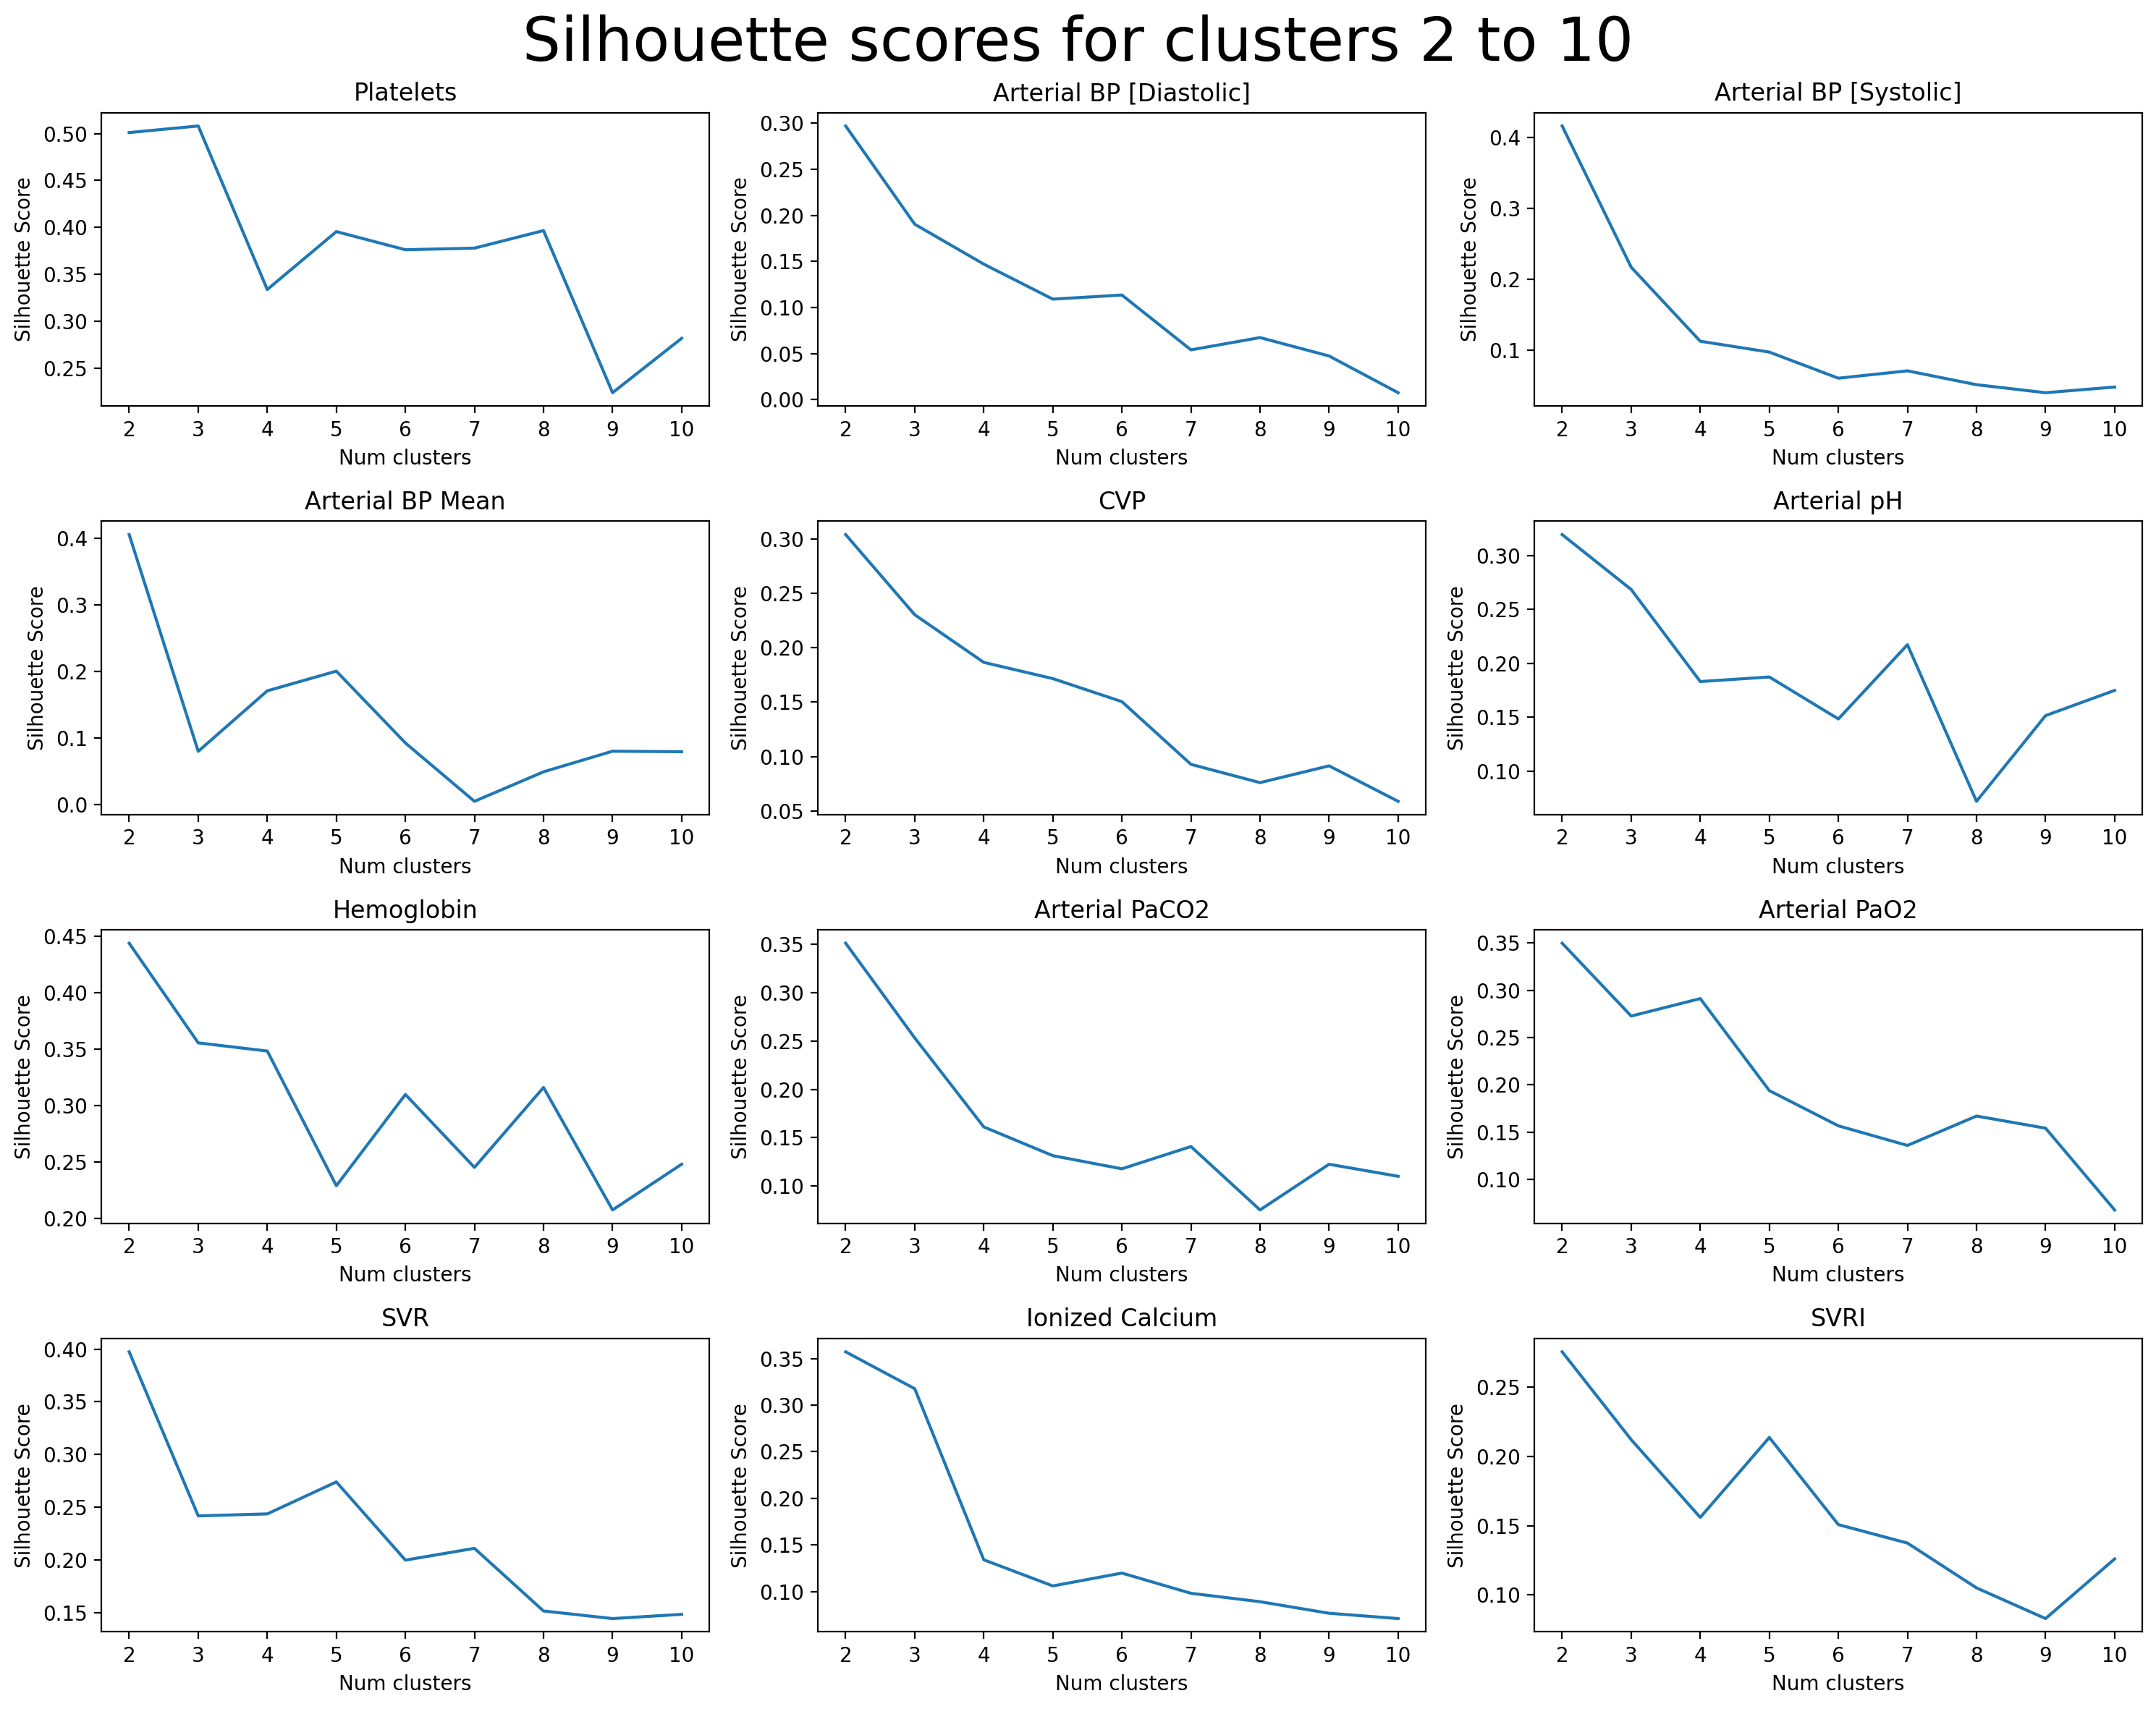

In [ ]:
# fig = plt.figure(figsize = (15, 12), dpi=200)

# for idx, col in enumerate(colScores):
#     scores = [x[1] for x in colScores[col]]
#     plt.subplot(4, len(colScores)//4, idx+1)
#     plt.title(col)
#     plt.ylabel("Silhouette Score")
#     plt.xlabel("Num clusters")
#     plt.plot(list(range(2,2+len(scores))), scores)
    
# fig.suptitle(f"Silhouette scores for clusters 2 to {1+len(scores)}", fontsize=30)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(colScores)

In [4]:
clusteredDF.describe()

HR         O2Sat          Resp           MAP           SBP  \
count  34028.000000  34028.000000  34028.000000  34028.000000  34028.000000   
mean       0.423122      0.016751      0.468879      0.403286      0.460268   
std        0.494062      0.128339      0.499038      0.490564      0.498426   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               Temp       Glucose     Potassium           BUN    Creatinine  \
count  34028.000000  34028.000000  34028.000000  34028.000000  34028.000000   
mean       0.860027      0.000147      0.000059      0.116522      0.070883   
std        0.346964      0.012121      0.007666      0.320854      0.256633   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                Hct           Hgb     Platelets           WBC     Magnesium  
count  34028.000000  34028.000000  34028.000000  34028.000000  34028.000000  
mean       0.603268      0.439432      0.509610      0.563918      0.133802  
std        0.489227      0.496325      0.499915      0.495905      0.340444  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        1.000000      0.000000      1.000000      1.000000      0.000000  
75%        1.000000      1.000000      1.000000      1.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000

In [41]:
def silhouetteScoreCalc(data, y_pred, test_size=0.1):

    sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
    # print(y_pred)
    test_sample_x = data[sample_idx]
    test_sample_y = [y_pred[i] for i in sample_idx]
    
    while len(np.unique(test_sample_y)) < 2:
        print("Recalculating sample due to too few clusters")
        sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
        test_sample_x = data[sample_idx]
        test_sample_y = [y_pred[i] for i in sample_idx]

    print(len(test_sample_x), len(test_sample_y))
    print("Calculating sil score...")

    score = silhouette_score(test_sample_x, test_sample_y, metric='dtw', n_jobs=4)

    return score


In [42]:


scores = {}

# Using sampling for the silhouette score since calculating the score on the entire dataset takes ages
# Is this calculated right? Sampling gives poor results
for column in tqdm(clusteredDF.columns):
    y_pred = list(clusteredDF[column])
    dataFormatted = formatForTimeSeries(column)
    
    score = silhouetteScoreCalc(dataFormatted, y_pred, test_size=0.01)


    scores[column] = score

print(scores)

# display(clusteredDF)

  0%|          | 0/15 [00:00<?, ?it/s]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


  7%|▋         | 1/15 [01:44<24:26, 104.72s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 13%|█▎        | 2/15 [03:27<22:28, 103.72s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 20%|██        | 3/15 [05:56<24:53, 124.45s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 27%|██▋       | 4/15 [08:00<22:43, 123.95s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 33%|███▎      | 5/15 [09:48<19:44, 118.41s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 40%|████      | 6/15 [10:39<14:18, 95.36s/it] 

Creating stacked DF...
Cleaning
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample du

 47%|████▋     | 7/15 [12:58<14:37, 109.69s/it]

Creating stacked DF...
Cleaning
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
340 340
Calculating sil score...


 53%|█████▎    | 8/15 [16:07<15:43, 134.83s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 60%|██████    | 9/15 [18:13<13:13, 132.29s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 67%|██████▋   | 10/15 [20:34<11:13, 134.75s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 73%|███████▎  | 11/15 [23:24<09:42, 145.55s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 80%|████████  | 12/15 [26:17<07:42, 154.13s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 87%|████████▋ | 13/15 [27:31<04:19, 129.74s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


 93%|█████████▎| 14/15 [28:42<01:51, 111.96s/it]

Creating stacked DF...
Cleaning
340 340
Calculating sil score...


100%|██████████| 15/15 [30:07<00:00, 120.50s/it]

{'HR': 0.3962914675754236, 'O2Sat': 0.5083800832833961, 'Resp': 0.20872537550756723, 'MAP': 0.3514246164954153, 'SBP': 0.3542298411207555, 'Temp': 0.33910270702463585, 'Glucose': 0.9694571255709402, 'Potassium': 0.9628949223585684, 'BUN': 0.7385036311363979, 'Creatinine': 0.8570624383300733, 'Hct': 0.5473982623511969, 'Hgb': 0.48630280844385887, 'Platelets': 0.46955336761636335, 'WBC': 0.42274768844407634, 'Magnesium': 0.5480390268447495}


In [43]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [14]:
def removeOutliers(data, threshold):
    stdDev = np.nanstd(data)
    # print(stdDev)
    mean = np.nanmean(data)
    # print(mean)
    normalised = [np.nanmean(np.abs(d - mean)) for d in data]
    mask = normalised < threshold * stdDev
    return data[mask], data[np.logical_not(mask)]

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


Feature       StdDev        Mean
0           HR    11.674412   75.263229
1           HR    12.965316   96.484716
2        O2Sat     2.550465   97.343287
3        O2Sat     6.912175   95.507201
4         Resp     3.879214   16.513264
5         Resp     4.890886   20.883793
6          MAP    11.410509   74.770268
7          MAP    14.671937   93.313586
8          SBP    15.426565  110.629313
9          SBP    20.635070  137.611479
10        Temp     0.660872   37.654162
11        Temp     0.592796   36.769462
12     Glucose    38.168913  127.698023
13     Glucose  1095.862999  925.709023
14   Potassium     0.514034    4.049991
15   Potassium    17.832761    1.746744
16         BUN     6.884820   15.957180
17         BUN    17.583774   57.217361
18  Creatinine     0.369612    0.935084
19  Creatinine     2.071211    5.785945
20         Hct     3.234219   36.577600
21         Hct     3.246277   28.558510
22         Hgb     1.103581    9.390612
23         Hgb     1.210000   12.114823
24   Platelets    61.937478  260.717022
25   Platelets    38.595953  137.349752
26         WBC     4.177366   14.661255
27         WBC     2.086208    8.036235
28   Magnesium     0.229804    1.980608
29   Magnesium     0.345381    2.506843

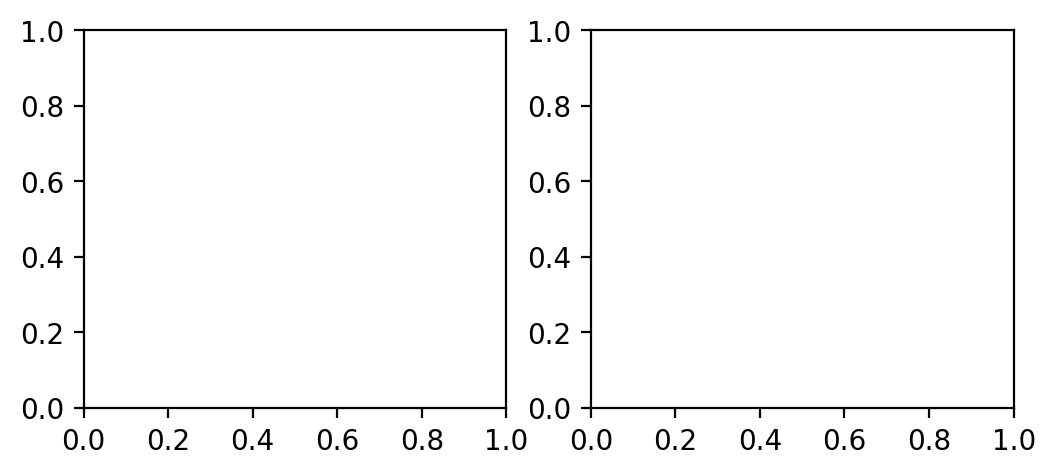

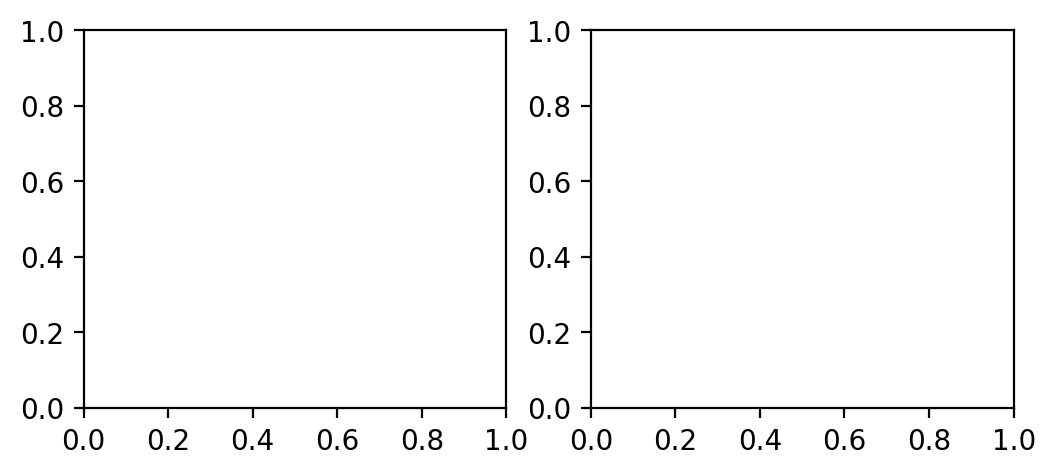

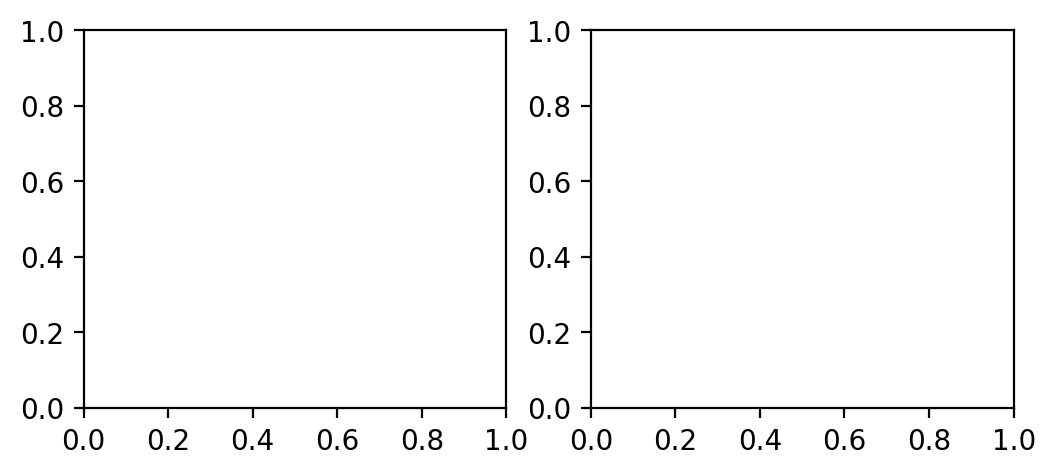

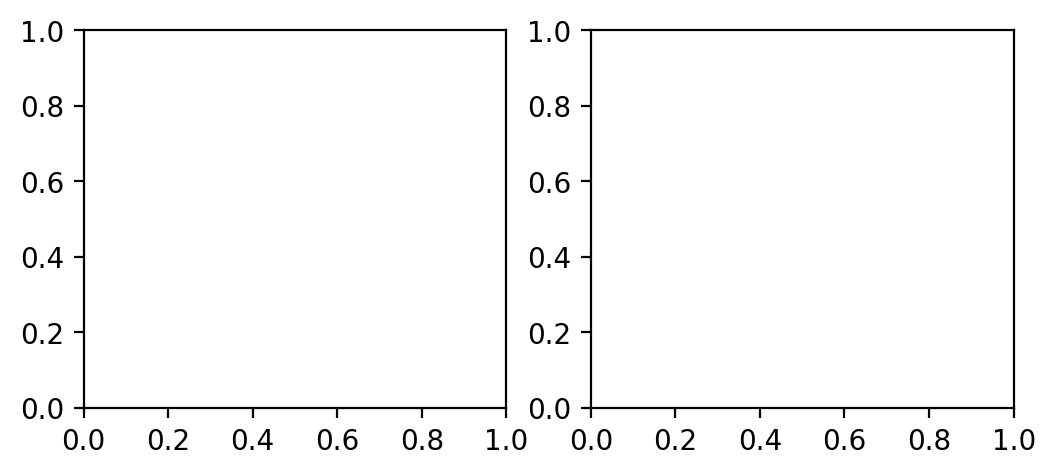

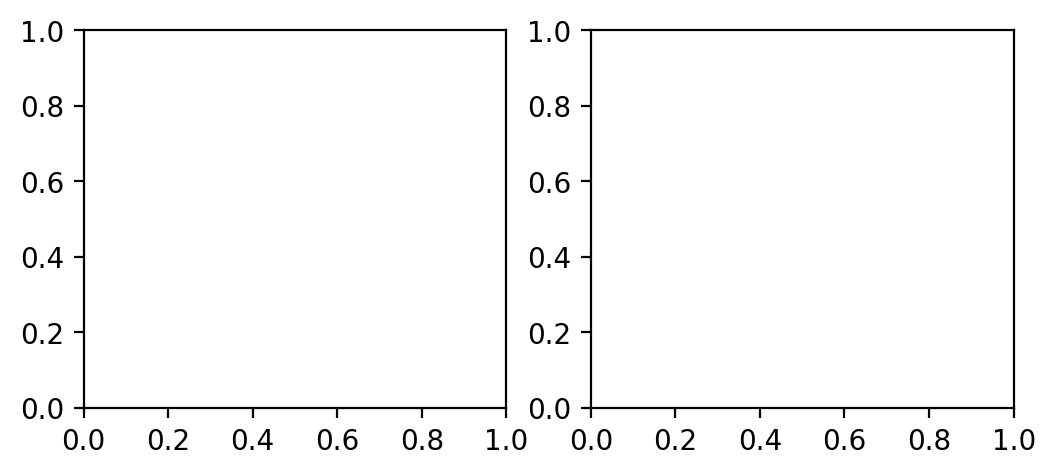

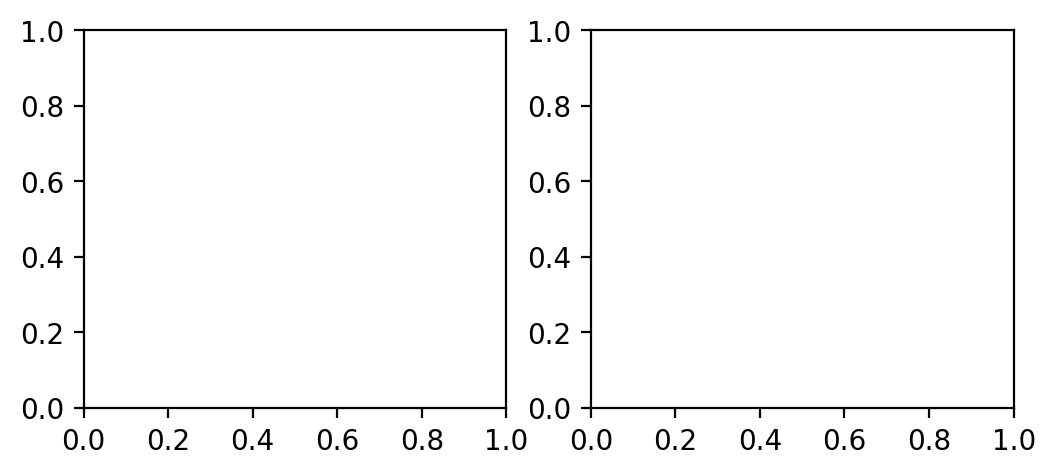

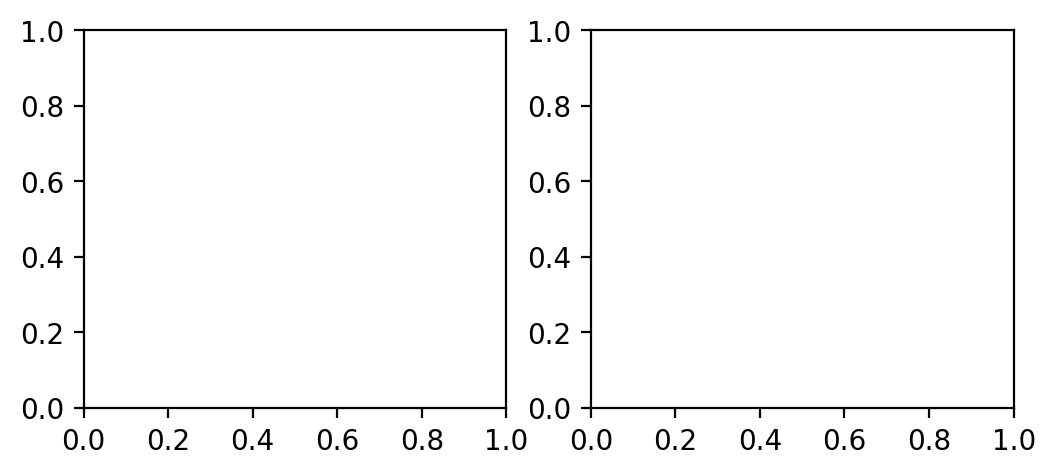

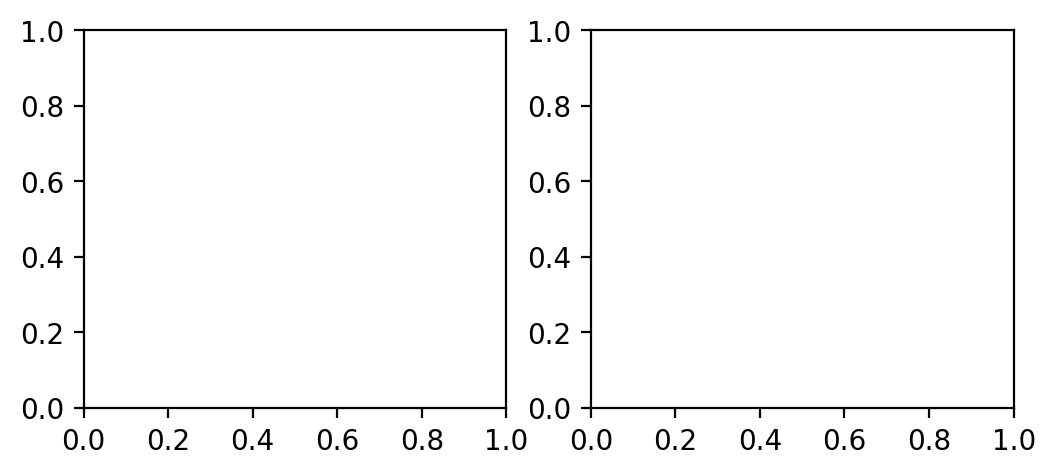

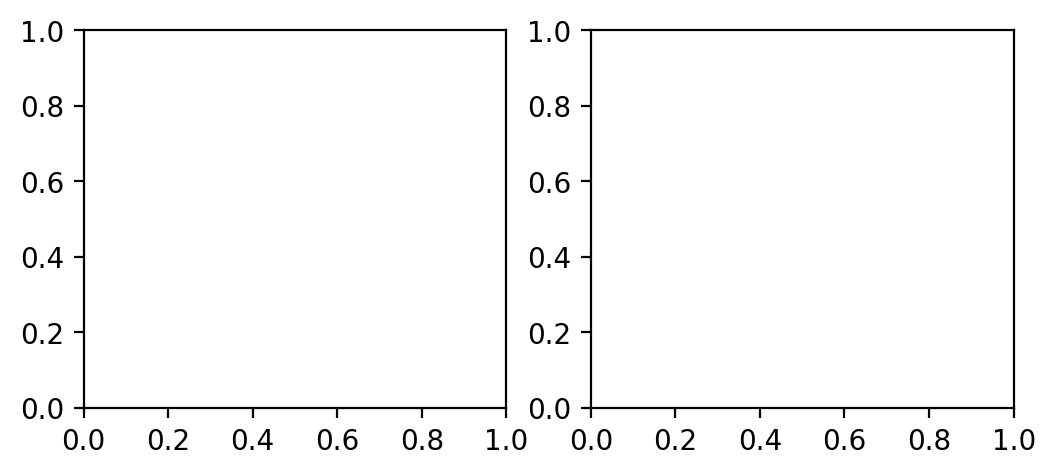

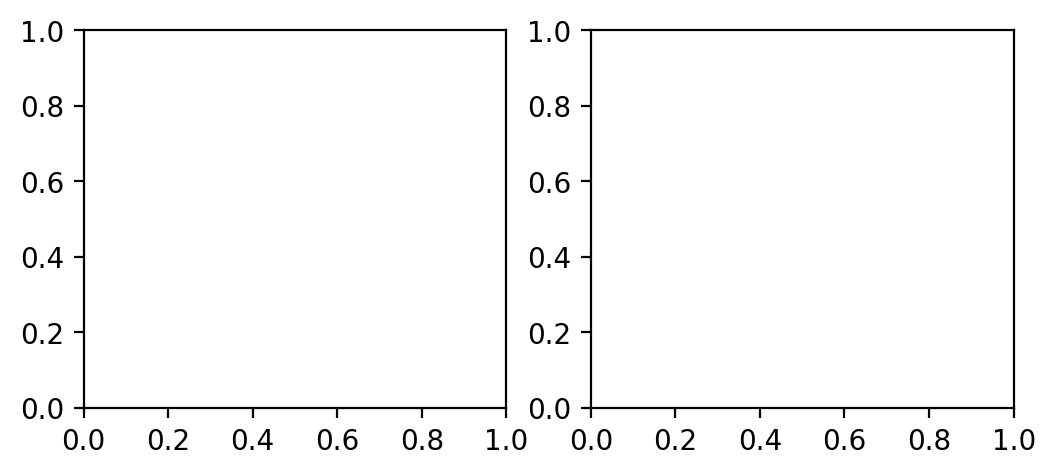

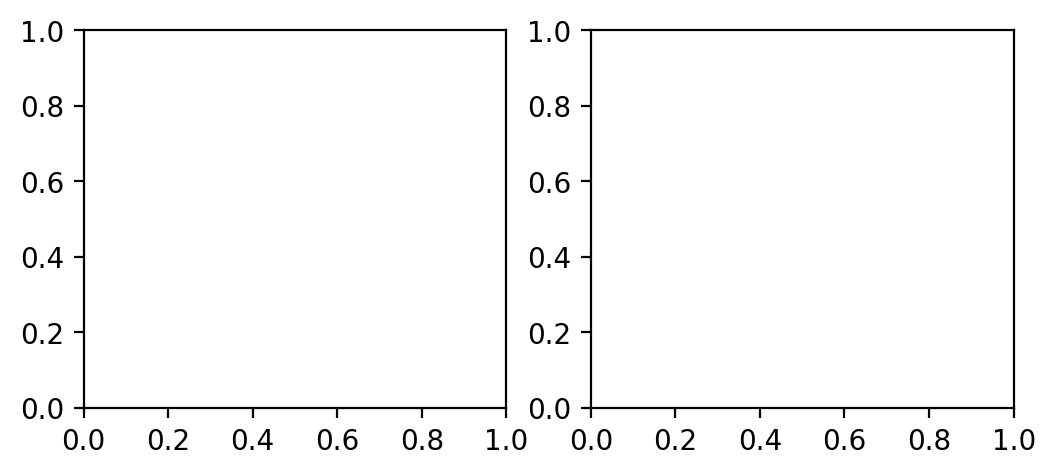

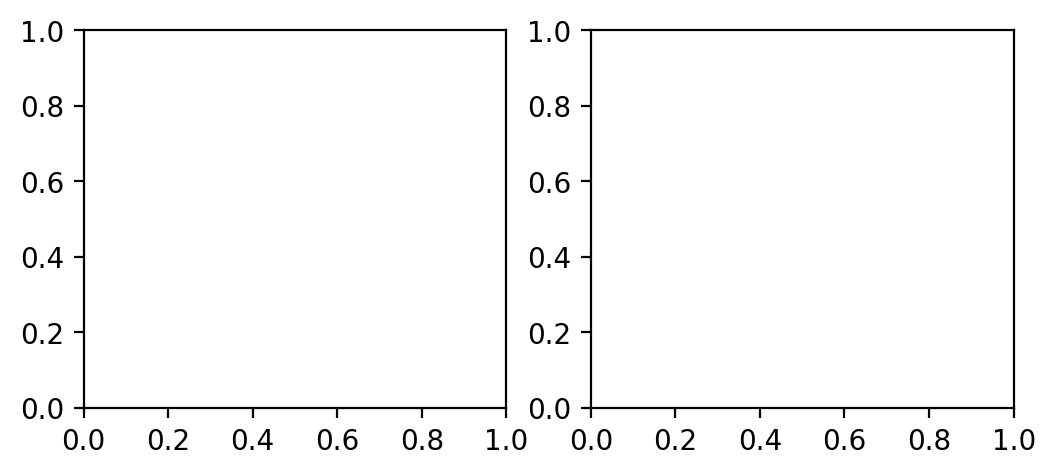

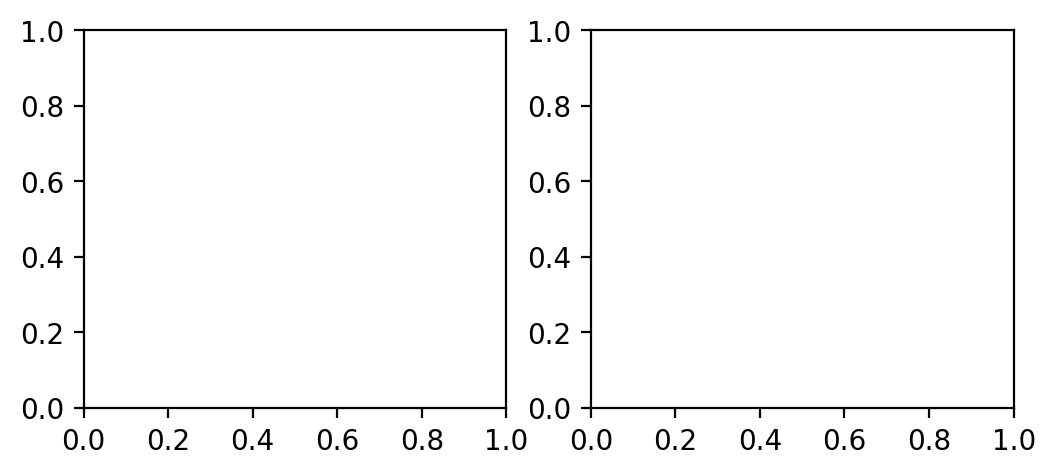

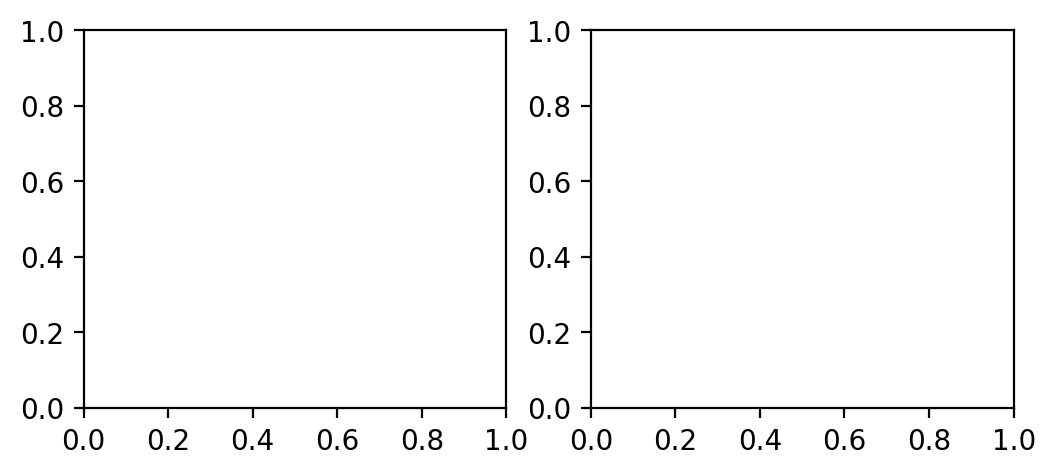

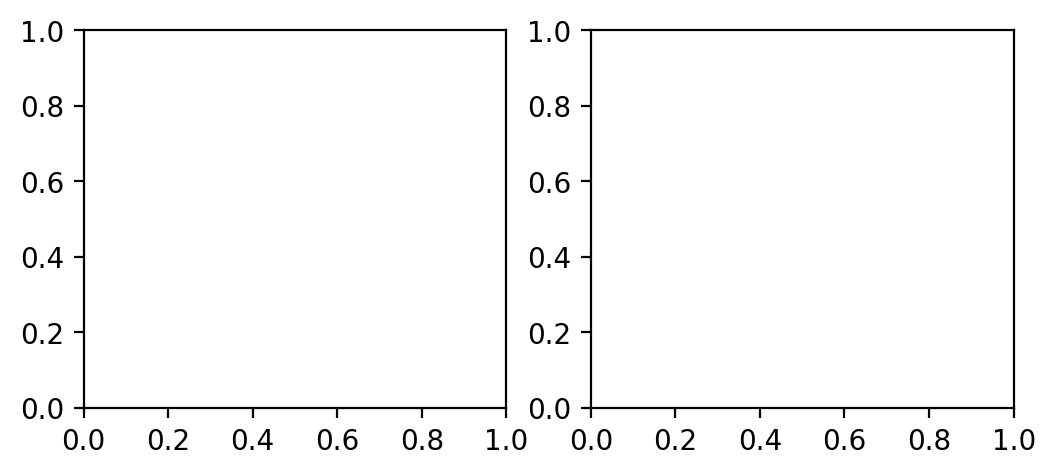

In [15]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}

clusterMetricsList = []

for col in clusteringPatients[0].interpolatedData.columns:

    clusters = 2

    fig = plt.figure(figsize=(clusters*3,2.5), dpi=200)

    # fig.suptitle(f"{col}, Sil score: {np.round(scores[col], 2)}", fontsize=20)
    

    # colData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]
    # print(colData)

    colData = [j.interpolatedData[col].values for j in clusteringPatients]

    minVal, maxVal = np.nanmin([np.nanmin(j) for j in colData]), np.nanmax([np.nanmax(j) for j in colData])

    for i in range(clusters):
        plt.subplot(1, clusters, i+1)

        y_pred = clusteredDF[col]

        # dataCluster = np.array(colData)[y_pred == i]

        dataCluster = formatForTimeSeries(col)[y_pred == i]

        withoutOutliers, outliers = removeOutliers(dataCluster, 1.5)
        
        # print(f"Num removed: {len(dataCluster) - len(withoutOutliers)}")

        # print(len(dataCluster))
        # print(len(withoutOutliers))
        
        # for sample in outliers:
        #     plt.plot(sample, c='black', alpha=0.05, linewidth=1)
        
        # for sample in withoutOutliers:
        #     plt.plot(sample, c=colours[i], alpha=0.1, linewidth=1)

        stdDev = np.nanstd(withoutOutliers)
        mean = np.nanmean(withoutOutliers)

        clusterMetricsList.append([col, stdDev, mean])

        # plt.title(f"C {i+1}, std: {np.round(stdDev, 2)}, mean: {np.round(mean, 2)}")
        # plt.xlabel("Time")
        # plt.ylabel("Value")
        # # print(dataCluster)
        # # print(np.nanstd(dataCluster))
        # plt.ylim(minVal, maxVal)

        
    # plt.tight_layout()
    # plt.savefig(f"./figures/sepsis/{col}.png")
    # plt.show()
    


clusterMetricsDF = pd.DataFrame(data = clusterMetricsList, columns=['Feature', 'StdDev', 'Mean'])
display(clusterMetricsDF)


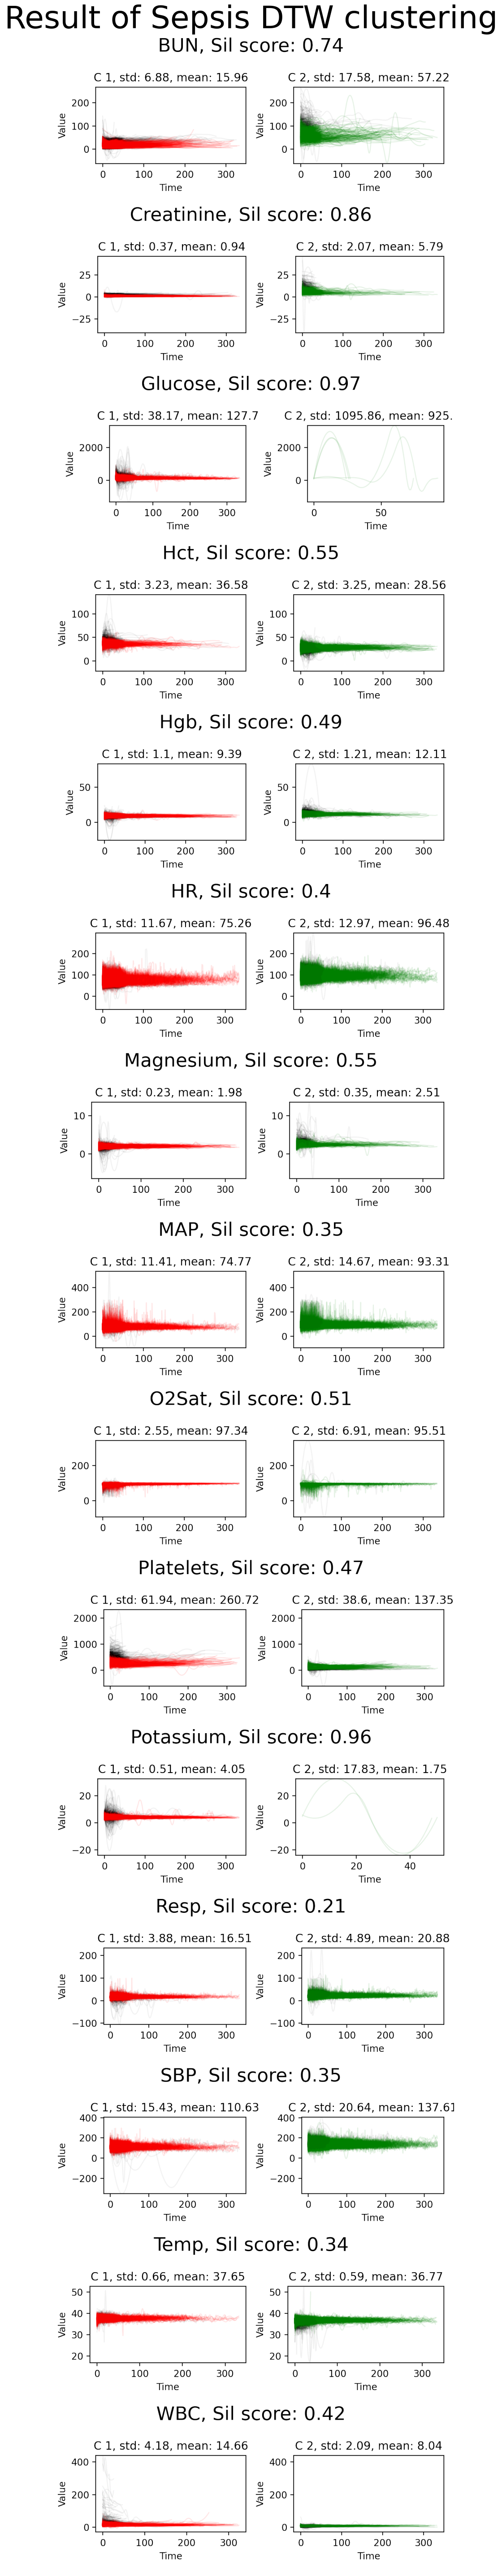

In [49]:
figdir = "./figures/sepsis/"

images = [Image.open(figdir + x) for x in list(next(os.walk(figdir))[2:])[0]]

widths, heights = zip(*(i.size for i in images))

widthMax = max(widths)
widthMin = min(widths)
heightTotal = sum(heights)

combined = Image.new('RGBA', (widthMax, heightTotal))

offset = 0
for im in images:
  xOffset = 0
  if im.size[0] != widthMax:
    xOffset = (widthMax - im.size[0]) // 2
  combined.paste(im, (xOffset, offset))
  offset += im.size[1]


fig = plt.figure(figsize=(widthMax/100, heightTotal/100), dpi=100)
plt.title("Result of Sepsis DTW clustering", fontsize=50)
plt.axis('off')
# plt.tight_layout()
plt.imshow(combined)
plt.show()


# new_im.save('test.jpg')

### Order by std dev to find the clusters that vary the most, order by mean to find the highest/lowest values.

In [45]:
# from sklearn.preprocessing import KBinsDiscretizer  
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

display(clusteredDF.head())

# orderedDF = copy.copy(clusteredDF)

def getMapping(metric, subset):
    
    ordered = subset.reset_index().sort_values(by=metric, ascending=True)

    before = ordered.index
    after = ordered.reset_index().index

    mapping = {before[i]: after[i] for i in range(len(before))}

    return mapping



orderedDF = pd.DataFrame()

for name, subset in clusterMetricsDF.groupby('Feature'):

    # clusterData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]

    for metric in list(clusterMetricsDF.columns)[1:]:

        mapping = getMapping(metric, subset)

        newCol = str(name + "_" + metric)

        orderedDF[newCol] = clusteredDF[name].map(mapping)


# orderedDF = orderedDF.set_index(clusteredDF.index)


display(orderedDF.head())


HR  O2Sat  Resp  MAP  SBP  Temp  Glucose  Potassium  BUN  \
PatientID                                                             
p000001     1      0     1    1    1     1        0          0    0   
p000002     0      0     0    0    1     1        0          0    1   
p000003     0      0     1    0    1     0        0          0    0   
p000004     1      0     1    0    0     1        0          0    0   
p000005     0      0     0    1    1     1        0          0    0   

           Creatinine  Hct  Hgb  Platelets  WBC  Magnesium  
PatientID                                                   
p000001             0    0    1          0    1          0  
p000002             0    1    0          1    0          1  
p000003             0    1    0          0    1          1  
p000004             0    1    0          1    1          0  
p000005             0    0    1          0    1          1

BUN_StdDev  BUN_Mean  Creatinine_StdDev  Creatinine_Mean  \
PatientID                                                             
p000001             0         0                  0                0   
p000002             1         1                  0                0   
p000003             0         0                  0                0   
p000004             0         0                  0                0   
p000005             0         0                  0                0   

           Glucose_StdDev  Glucose_Mean  HR_StdDev  HR_Mean  Hct_StdDev  \
PatientID                                                                 
p000001                 0             0          1        1           0   
p000002                 0             0          0        0           1   
p000003                 0             0          0        0           1   
p000004                 0             0          1        1           1   
p000005                 0             0          0        0           0   

           Hct_Mean  ...  Potassium_StdDev  Potassium_Mean  Resp_StdDev  \
PatientID            ...                                                  
p000001           1  ...                 0               1            1   
p000002           0  ...                 0               1            0   
p000003           0  ...                 0               1            1   
p000004           0  ...                 0               1            1   
p000005           1  ...                 0               1            0   

           Resp_Mean  SBP_StdDev  SBP_Mean  Temp_StdDev  Temp_Mean  \
PatientID                                                            
p000001            1           1         1            0          0   
p000002            0           1         1            0          0   
p000003            1           1         1            1          1   
p000004            1           0         0            0          0   
p000005            0           1         1            0          0   

           WBC_StdDev  WBC_Mean  
PatientID                        
p000001             0         0  
p000002             1         1  
p000003             0         0  
p000004             0         0  
p000005             0         0  

[5 rows x 30 columns]

In [27]:
staticVals = [p.static.max().values for p in clusteringPatients]


staticDF = pd.DataFrame(data = staticVals, columns=staticColumns)

ids = [p.patientID for p in clusteringPatients]

staticDF['PatientID'] = ids

staticDF = staticDF.set_index("PatientID")

staticDF = staticDF.apply(lambda x: x.fillna(x.mean()))

staticDF


Age  Gender     Unit1     Unit2  HospAdmTime  ICULOS
PatientID                                                        
p000001    83.14     0.0  0.492377  0.507623        -0.03    54.0
p000002    75.91     0.0  0.000000  1.000000       -98.60    23.0
p000003    45.82     0.0  1.000000  0.000000     -1195.71    48.0
p000004    65.71     0.0  0.000000  1.000000        -8.77    29.0
p000005    28.09     1.0  1.000000  0.000000        -0.05    49.0
...          ...     ...       ...       ...          ...     ...
p119995    76.00     1.0  0.000000  1.000000       -14.90    42.0
p119996    84.00     0.0  0.492377  0.507623        -6.69    48.0
p119997    30.00     1.0  0.492377  0.507623        -0.02    25.0
p119998    60.00     0.0  1.000000  0.000000       -53.64    49.0
p120000    62.00     0.0  0.492377  0.507623         0.00    35.0

[34028 rows x 6 columns]

In [52]:
reload(Categorization)

cat = Categorization.Categorizer(staticDF)

binnedDF = cat.kBins(2, 'uniform')

binnedDF['PatientID'] = ids

binnedDF = binnedDF.set_index("PatientID")

binnedDF = binnedDF.astype(np.int64)

binnedDF

Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS
PatientID                                                
p000001      1       0      0      1            1       0
p000002      1       0      0      1            1       0
p000003      0       0      1      0            1       0
p000004      1       0      0      1            1       0
p000005      0       1      1      0            1       0
...        ...     ...    ...    ...          ...     ...
p119995      1       1      0      1            1       0
p119996      1       0      0      1            1       0
p119997      0       1      0      1            1       0
p119998      1       0      1      0            1       0
p120000      1       0      0      1            1       0

[34028 rows x 6 columns]

In [53]:
orderedDF[staticColumns] = binnedDF[staticColumns]

orderedDF

BUN_StdDev  BUN_Mean  Creatinine_StdDev  Creatinine_Mean  \
PatientID                                                             
p000001             0         0                  0                0   
p000002             1         1                  0                0   
p000003             0         0                  0                0   
p000004             0         0                  0                0   
p000005             0         0                  0                0   
...               ...       ...                ...              ...   
p119995             0         0                  0                0   
p119996             0         0                  0                0   
p119997             0         0                  0                0   
p119998             1         1                  1                1   
p120000             0         0                  0                0   

           Glucose_StdDev  Glucose_Mean  HR_StdDev  HR_Mean  Hct_StdDev  \
PatientID                                                                 
p000001                 0             0          1        1           0   
p000002                 0             0          0        0           1   
p000003                 0             0          0        0           1   
p000004                 0             0          1        1           1   
p000005                 0             0          0        0           0   
...                   ...           ...        ...      ...         ...   
p119995                 0             0          0        0           0   
p119996                 0             0          1        1           0   
p119997                 0             0          0        0           0   
p119998                 0             0          0        0           1   
p120000                 0             0          0        0           0   

           Hct_Mean  ...  Temp_StdDev  Temp_Mean  WBC_StdDev  WBC_Mean  Age  \
PatientID            ...                                                      
p000001           1  ...            0          0           0         0    1   
p000002           0  ...            0          0           1         1    1   
p000003           0  ...            1          1           0         0    0   
p000004           0  ...            0          0           0         0    1   
p000005           1  ...            0          0           0         0    0   
...             ...  ...          ...        ...         ...       ...  ...   
p119995           1  ...            0          0           0         0    1   
p119996           1  ...            0          0           1         1    1   
p119997           1  ...            0          0           0         0    0   
p119998           0  ...            0          0           1         1    1   
p120000           1  ...            0          0           0         0    1   

           Gender  Unit1  Unit2  HospAdmTime  ICULOS  
PatientID                                             
p000001         0      0      1            1       0  
p000002         0      0      1            1       0  
p000003         0      1      0            1       0  
p000004         0      0      1            1       0  
p000005         1      1      0            1       0  
...           ...    ...    ...          ...     ...  
p119995         1      0      1            1       0  
p119996         0      0      1            1       0  
p119997         1      0      1            1       0  
p119998         0      1      0            1       0  
p120000         0      0      1            1       0  

[34028 rows x 36 columns]

In [54]:
reload(Categorization)

cat = Categorization.Categorizer()

mapping = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

mapped = cat.map_types(data = {"ordered":orderedDF}, mapping=mapping)['ordered']

display(mapped)

BUN_StdDev_high  BUN_StdDev_low  BUN_Mean_high  BUN_Mean_low  \
PatientID                                                                 
p000001                  0               1              0             1   
p000002                  1               0              1             0   
p000003                  0               1              0             1   
p000004                  0               1              0             1   
p000005                  0               1              0             1   
...                    ...             ...            ...           ...   
p119995                  0               1              0             1   
p119996                  0               1              0             1   
p119997                  0               1              0             1   
p119998                  1               0              1             0   
p120000                  0               1              0             1   

           Creatinine_StdDev_high  Creatinine_StdDev_low  \
PatientID                                                  
p000001                         0                      1   
p000002                         0                      1   
p000003                         0                      1   
p000004                         0                      1   
p000005                         0                      1   
...                           ...                    ...   
p119995                         0                      1   
p119996                         0                      1   
p119997                         0                      1   
p119998                         1                      0   
p120000                         0                      1   

           Creatinine_Mean_high  Creatinine_Mean_low  Glucose_StdDev_high  \
PatientID                                                                   
p000001                       0                    1                    0   
p000002                       0                    1                    0   
p000003                       0                    1                    0   
p000004                       0                    1                    0   
p000005                       0                    1                    0   
...                         ...                  ...                  ...   
p119995                       0                    1                    0   
p119996                       0                    1                    0   
p119997                       0                    1                    0   
p119998                       1                    0                    0   
p120000                       0                    1                    0   

           Glucose_StdDev_low  ...  Gender_high  Gender_low  Unit1_high  \
PatientID                      ...                                        
p000001                     1  ...            0           1           0   
p000002                     1  ...            0           1           0   
p000003                     1  ...            0           1           1   
p000004                     1  ...            0           1           0   
p000005                     1  ...            1           0           1   
...                       ...  ...          ...         ...         ...   
p119995                     1  ...            1           0           0   
p119996                     1  ...            0           1           0   
p119997                     1  ...            1           0           0   
p119998                     1  ...            0           1           1   
p120000                     1  ...            0           1           0   

           Unit1_low  Unit2_high  Unit2_low  HospAdmTime_high  \
PatientID                                                       
p000001            1           1          0                 1   
p000002            1           1          0                 1   
p000003         

In [55]:
targetSeries = [patient.label for patient in clusteringPatients]

# targetSeries

In [56]:
mapped['Mortality14Days'] = targetSeries

display(mapped)

mapped.to_csv("./categorisedData/clusteredDataSepsis.csv")

BUN_StdDev_high  BUN_StdDev_low  BUN_Mean_high  BUN_Mean_low  \
PatientID                                                                 
p000001                  0               1              0             1   
p000002                  1               0              1             0   
p000003                  0               1              0             1   
p000004                  0               1              0             1   
p000005                  0               1              0             1   
...                    ...             ...            ...           ...   
p119995                  0               1              0             1   
p119996                  0               1              0             1   
p119997                  0               1              0             1   
p119998                  1               0              1             0   
p120000                  0               1              0             1   

           Creatinine_StdDev_high  Creatinine_StdDev_low  \
PatientID                                                  
p000001                         0                      1   
p000002                         0                      1   
p000003                         0                      1   
p000004                         0                      1   
p000005                         0                      1   
...                           ...                    ...   
p119995                         0                      1   
p119996                         0                      1   
p119997                         0                      1   
p119998                         1                      0   
p120000                         0                      1   

           Creatinine_Mean_high  Creatinine_Mean_low  Glucose_StdDev_high  \
PatientID                                                                   
p000001                       0                    1                    0   
p000002                       0                    1                    0   
p000003                       0                    1                    0   
p000004                       0                    1                    0   
p000005                       0                    1                    0   
...                         ...                  ...                  ...   
p119995                       0                    1                    0   
p119996                       0                    1                    0   
p119997                       0                    1                    0   
p119998                       1                    0                    0   
p120000                       0                    1                    0   

           Glucose_StdDev_low  ...  Gender_low  Unit1_high  Unit1_low  \
PatientID                      ...                                      
p000001                     1  ...           1           0          1   
p000002                     1  ...           1           0          1   
p000003                     1  ...           1           1          0   
p000004                     1  ...           1           0          1   
p000005                     1  ...           0           1          0   
...                       ...  ...         ...         ...        ...   
p119995                     1  ...           0           0          1   
p119996                     1  ...           1           0          1   
p119997                     1  ...           0           0          1   
p119998                     1  ...           1           1          0   
p120000                     1  ...           1           0          1   

           Unit2_high  Unit2_low  HospAdmTime_high  HospAdmTime_low  \
PatientID                                                             
p000001             1          0                 1                0   
p000002             1          0                 1                0   
p000003           

In [54]:
mapped['Mortality14Days'].value_counts()

0    31606
1     2422
Name: Mortality14Days, dtype: int64